# Assignment 2

In this assignment, we first take a closer look at Transformer architecture then, we explore some applications of the BERT model.

Refrences and useful liks:


* [https://self-supervised.cs.jhu.edu/](https://ttps://self-supervised.cs.jhu.edu/)
* [https://www.sbert.net/index.html](https://https://www.sbert.net/index.html)
* [https://huggingface.co/docs/transformers/model_doc/bert](https://https://huggingface.co/docs/transformers/model_doc/bert)

# Part1: Transformers

What do *BERT, RoBERTa, ALBERT, SpanBERT, DistilBERT, SesameBERT, SemBERT, MobileBERT, TinyBERT and CamemBERT* all have in common? And I’m not looking for the answer “BERT” 🤭.
Answer: **self-attention** 🤗. We are not only talking about architectures bearing the name “BERT’, but more correctly **Transformer-based architectures**. Transformer-based architectures, which are primarily used in modelling language understanding tasks, eschew the use of recurrence in neural network (RNNs) and instead trust entirely on self-attention mechanisms to draw global dependencies between inputs and outputs.


**Some useful documentation: ** In the first part of this notebook, we will implement the Transformer architecture by hand.
As the architecture is so popular, there already exists a Pytorch module `nn.Transformer`
([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html))
and a [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)
on how to use it for next token prediction.
However, we will implement it here ourselves, to get through to the smallest details.

There are of course many more tutorials out there about attention and Transformers.
Below, we list a few that are worth exploring if you are interested in the topic
and might want yet another perspective on the topic after this one:

* [Transformer: A Novel Neural Network Architecture for Language Understanding
(Jakob Uszkoreit, 2017)](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) - The original Google blog post about the Transformer paper, focusing on the application in machine translation.
* [The Illustrated Transformer (Jay Alammar, 2018)](http://jalammar.github.io/illustrated-transformer/) - A very popular and great blog post intuitively explaining the Transformer architecture with many nice visualizations.
The focus is on NLP.
* [Attention?
Attention!
(Lilian Weng, 2018)](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) - A nice blog post summarizing attention mechanisms in many domains including vision.
* [Illustrated: Self-Attention (Raimi Karim, 2019)](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a) - A nice visualization of the steps of self-attention.
Recommended going through if the explanation below is too abstract for you.
* [The Transformer family (Lilian Weng, 2020)](https://lilianweng.github.io/lil-log/2020/04/07/the-transformer-family.html) - A very detailed blog post reviewing more variants of Transformers besides the original one.


### What is Attention?

The attention mechanism describes a recent new group of layers in neural networks that has attracted
a lot of interest in the past few years, especially in sequence tasks.
There are a lot of different possible definitions of "attention" in the literature,
but the one we will use here is the following: _the attention mechanism describes a weighted average
of (sequence) elements with the weights dynamically computed based on an input query and elements' keys_.
So what does this exactly mean?
The goal is to take an average of the features of multiple elements.
However, instead of weighting each element equally, we want to weight them depending on their actual values.
In other words, we want to dynamically decide on which inputs we want to "attend" more than others.
In particular, an attention mechanism has usually four parts we need to specify:

* **Query**: The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.
* **Keys**: For each input element, we have a key which is again a feature vector.
This feature vector roughly describes what the element is "offering", or when it might be important.
The keys should be designed such that we can identify the elements we want to pay attention to based on the query.
* **Values**: For each input element, we also have a value vector.
This feature vector is the one we want to average over.
* **Score function**: To rate which elements we want to pay attention to, we need to specify a score function $f_{attn}$.
The score function takes the query and a key as input, and outputs the score/attention weight of the query-key pair.
It is usually implemented by simple similarity metrics like a dot product, or a small MLP.


The weights of the average are calculated by a softmax overall score function outputs.
Hence, we assign those value vectors a higher weight whose corresponding key is most similar to the query.
If we try to describe it with pseudo-math, we can write:

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Visually, we can show the attention over a sequence of words as follows:

<center width="100%" style="padding:25px"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/attention_example.svg" width="750px"></center>

For every word, we have one key and one value vector.
The query is compared to all keys with a score function (in this case the dot product) to determine the weights.
The softmax is not visualized for simplicity.
Finally, the value vectors of all words are averaged using the attention weights.

Most attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined,
and what score function is used.
The attention applied inside the Transformer architecture is called **self-attention**.
In self-attention, each sequence element provides a key, value, and query.
For each element, we perform an attention layer where based on its query,
we check the similarity of all sequence elements' keys and returned a different,
averaged value vector for each element.
We will now go into a bit more detail by first looking at the specific implementation of the attention mechanism
which is in the Transformer case the scaled dot product attention.

### Scaled Dot Product Attention

The core concept behind self-attention is the scaled dot product attention.
Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while
still being efficient to compute.
The dot product attention takes as input a set of queries
$Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$
and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length,
and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively.
For simplicity, we neglect the batch dimension for now.
The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$,
using the dot product as the similarity metric.
In math, we calculate the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys,
resulting in a matrix of the shape $T\times T$.
Each row represents the attention logits for a specific element $i$ to all other elements in the sequence.
On these, we apply a softmax and multiply with the value vector to obtain a weighted mean
(the weights being determined by the attention).
Another perspective on this attention mechanism offers the computation graph which is visualized below
(figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/scaled_dot_product_attn.svg" width="210px"></center>

![texto alternativo](https://miro.medium.com/max/1973/1*G8thyDVqeD8WHim_QzjvFg.gif)


One aspect we haven't discussed yet is the scaling factor of $1/\sqrt{d_k}$.
This scaling factor is crucial to maintain an appropriate variance of attention values after initialization.
Remember that we initialize our layers to have equal variance throughout the model, and hence,
$Q$ and $K$ might also have a variance close to $1$.
However, performing a dot product over two vectors with a variance $\sigma$ results
in a scalar having $d_k$-times higher variance:

$$q_i \sim \mathcal{N}(0,\sigma), k_i \sim \mathcal{N}(0,\sigma) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma\cdot d_k$$


If we do not scale down the variance back to $\sigma$, the softmax over the logits will already saturate
to $1$ for one random element and $0$ for all others.
The gradients through the softmax will be close to zero so we can't learn the parameters appropriately.


*While we will not implement Transformers from scratch, however, we will read and interpret an existing implementation of a Transformer used for implementing the BERT model.*



## **Question 1**
Look at the implementation of [`BertSelfAttention`](https://github.com/huggingface/transformers/blob/8b3db33a763ccef828fca89bac7e6cbff314f131/src/transformers/models/bert/modeling_bert.py#L242-L373) in Huggingface. Explain how this implementation ties to the definition of Self-Attention introduced above. Also identify the positional embeddings and how they are implemented. (no more than 20 sentences)




<font color='red'>

1. **Initialization**: The class is initialized with configuration parameters that set up the necessary dimensions for the self-attention mechanism. The compatibility of hidden size with the number of attention heads is checked, ensuring each head gets an equal portion of the hidden size.
2. **Attention Heads Setup**: It defines the dimensions for each attention head and the combined size for all heads. This allows the model to process different segments of the input data separately within each attention head, a key aspect of the self-attention mechanism.
3. **Query, Key, Value Transformations**: Linear transformations create query, key, and value tensors from the input hidden states. These transformations are the first step in calculating attention scores, allowing each position in the input sequence to attend to every other position.
4. **Positional Embeddings**: The code supports two types of positional embeddings: absolute and relative. Absolute embeddings are assumed by default, which would be added to the token embeddings outside this class. For relative embeddings, it learns an embedding for each possible relative position between tokens, which is then used to compute attention scores, illustrating the model’s ability to factor in the order of the input sequence.
5. **Attention Scores Calculation**: The raw attention scores are computed by taking the dot product of the query with the key, followed by scaling to stabilize training. This reflects the core self-attention mechanism where a token’s influence on another is proportional to the dot product of their query and key vectors.
6. **Relative Positional Information**: When relative positional embeddings are enabled, they are directly added to the attention scores, which modifies the attention based on the distance between tokens. This is a sophisticated feature allowing the model to understand the sequence context better.
7. **Normalization and Masking**: Attention scores are normalized using a softmax function, and any necessary masking is applied to prevent the model from attending to certain positions (like padding tokens), ensuring the model's focus is on valid sequence parts.
8. **Context Vector Generation**: Finally, the model computes the context vectors by applying the attention probabilities to the value vectors. The context vectors are a weighted combination of value vectors, with weights indicating the relevance of each token’s information for the output.
9. **Output Structure**: The class returns the context layer, and optionally the attention probabilities, encapsulating the final weighted representations of the input sequence after self-attention has been applied.

</font>


### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence.
However, often there are multiple different aspects a sequence element wants to attend to,
and a single weighted average is not a good option for it.
This is why we extend the attention mechanisms to multiple heads,
i.e. multiple different query-key-value triplets on the same features.
Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys,
and sub-values, which we pass through the scaled dot product attention independently.
Afterward, we concatenate the heads and combine them with a final weight matrix.
Mathematically, we can express this operation as:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters
$W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$,
and $W^{O}\in\mathbb{R}^{h\cdot d_k\times d_{out}}$ ($D$ being the input dimensionality).
Expressed in a computational graph, we can visualize it below
(figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/multihead_attention.svg" width="230px"></center>







## **Question 2**
 Again look at the implementation of [`BertSelfAttention`](https://github.com/huggingface/transformers/blob/8b3db33a763ccef828fca89bac7e6cbff314f131/src/transformers/models/bert/modeling_bert.py#L242-L373) in Huggingface. Identify how **multiple heads** of Multi-Head Attention are implemented. Explain your understanding and tie it to the definition introduced above. (no more than 10 sentences)


<font color='red'>

1. **Attention Heads Setup**: The number of attention heads (`num_attention_heads`) and the size of each head (`attention_head_size`) are defined based on the model's hidden size. This configuration allows the model to have multiple sets of Q, K, and V vectors, one set for each head.
2. **Linear Transformations**: Separate linear layers for queries, keys, and values (`self.query`, `self.key`, `self.value`) transform the input hidden states into multiple sets of Q, K, and V vectors. These layers are shared across all attention heads, but they output vectors that are later split into multiple heads.
3. **Reshaping for Multi-Head Attention**: The `transpose_for_scores` function reshapes the linear layer outputs to separate the different attention heads. This is done by changing the shape of the tensor from `[batch_size, sequence_length, all_head_size]` to `[batch_size, num_attention_heads, sequence_length, attention_head_size]`.
4. **Attention Computation**: Each head computes attention scores independently. The attention mechanism is applied in parallel across the multiple heads, allowing the model to capture different types of information from the input sequence, such as syntactic and semantic features.
5. **Concatenation of Heads**: After computing the context vectors for each head, the results are concatenated and potentially reshaped to match the original input dimensionality before being passed to subsequent layers in the model.

</font>

Notice that there is a residual connection and normalization on top of the multi-head attention layer.

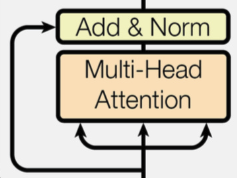

Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above.
The output is added to the original input using a residual connection,
and we apply a consecutive Layer Normalization on the sum.
Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$
($x$ being $Q$, $K$ and $V$ input to the attention layer).
The residual connection is crucial in the Transformer architecture for two reasons:

 1. Similar to ResNets, Transformers are designed to be very deep.
Some models contain more than 24 blocks in the encoder.
Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.
 2. Without the residual connection, the information about the original sequence is lost.
Remember that the Multi-Head Attention layer ignores the position of elements in a sequence,
and can only learn it based on the input features.
Removing the residual connections would mean that this information is lost after the first attention layer
(after initialization), and with a randomly initialized query and key vector,
the output vectors for position $i$ have no relation to its original input.
All outputs of the attention are likely to represent similar/same information,
and there is no chance for the model to distinguish which information came from which input element.
An alternative option to residual connection would be to fix at least one head to focus on its original input,
but this is very inefficient and does not have the benefit of the improved gradient flow.

The Layer Normalization also plays an important role in the Transformer architecture as it enables faster
training and provides small regularization.
Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence.
We are not using Batch Normalization because it depends on the batch size which is often small with Transformers
(they require a lot of GPU memory), and BatchNorm has shown to perform particularly badly in language
as the features of words tend to have a much higher variance (there are many, very rare words
which need to be considered for a good distribution estimate).





## **Question 3**
Look at the implementation of [`BertAttention`](https://github.com/huggingface/transformers/blob/8b3db33a763ccef828fca89bac7e6cbff314f131/src/transformers/models/bert/modeling_bert.py#L390-L437) in Huggingface. Identify how this class loads multi-head self-attention, and combines it with layer-normalization + residual-connection introduced above. (no more than 10 sentences)


<font color='red'>

1. **Instantiation of Multi-Head Self-Attention**: The `BertAttention` class initializes a `BertSelfAttention` object, which handles the computation of multi-head self-attention.
2. **Output Layer**: The `BertSelfOutput` is another component initialized within `BertAttention`. It typically handles the transformation of the multi-head attention's output and is where the residual connection and layer normalization would occur.
3. **Head Pruning**: The `prune_heads` method allows for the pruning of attention heads, which is a technique to remove certain heads after the model has been trained, potentially reducing the model's size and speeding up inference without a significant loss in performance.
4. **Forward Pass**: In the `forward` method, the input `hidden_states` are first passed through the `BertSelfAttention` instance. The resulting outputs are then passed to the `BertSelfOutput` object.
5. **Integration with Layer Normalization and Residual Connection**: Although not explicitly shown in this snippet, `BertSelfOutput` is typically responsible for applying a linear transformation to the self-attention outputs, adding a residual connection (by adding the input `hidden_states` to the attention outputs), and normalizing the result with layer normalization.
6. **Output Structure**: The class returns a tuple, with the first element being the attention output (after applying self-attention, residual connection, and normalization) and the rest being the outputs from the `BertSelfAttention` layer, which may include the raw attention scores if `output_attentions` is True.
</font>

### Transformer Encoder

<div class="center-wrapper"><div class="video-wrapper"><iframe src="https://www.youtube.com/embed/QdTgJ85E6YA" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div></div>

Originally, the Transformer model was designed for machine translation.
Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language
and generates an attention-based representation.
On the other hand, the decoder attends to the encoded information and generates the translated sentence
in an autoregressive manner, as in a standard RNN.
While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding,
we will focus here on the encoder part.
Many advances in NLP have been made using pure encoder-based Transformer models (including
[BERT](https://arxiv.org/abs/1810.04805)-family, and more),we will  mainly focus on the **encoder** part.
If you have understood the encoder architecture, the decoder is a very small step to implement as well.
The full Transformer architecture looks as follows
(figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)):

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/transformer_architecture.svg" width="400px"></center>

The encoder consists of $N$ identical blocks. These blocks contain Self-Attention, Layer Normalization, and Residual connections.


Additionally, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically.
Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP.
The full transformation including the residual connection can be expressed as:

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

This MLP adds extra complexity to the model and allows transformations on each sequence element separately.
You can imagine as this allows the model to "post-process" the new information added
by the previous Multi-Head Attention, and prepare it for the next attention block.
Usually, the inner dimensionality of the MLP is 2-8$\times$ larger than $d_{\text{model}}$,
i.e. the dimensionality of the original input $x$.
The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.







## **Question 4**
Look at the implementation of [`BertLayer`](https://github.com/huggingface/transformers/blob/8b3db33a763ccef828fca89bac7e6cbff314f131/src/transformers/models/bert/modeling_bert.py#L468-L551) in Huggingface. Identify how this class creates a complete transformer layer.  In particular, how it incorporates self-attention and ML introduced earlier. (no more than 10 sentences)

<font color='red'>

1. **Initialization**: In the `__init__` method, the class initializes the self-attention mechanism (`BertAttention`) and the feed-forward network components (`BertIntermediate` and `BertOutput`). It also sets up for potential cross-attention layers if the layer is to be used in a decoder context.
2. **Forward Pass**: The `forward` method is where the actual computation takes place. The input `hidden_states` are passed through the self-attention mechanism first. If the layer is part of a decoder and cross-attention is added, it handles the attention mechanism using encoder hidden states as well.
3. **Self-Attention**: The self-attention module (`self.attention`) performs multi-head self-attention on the `hidden_states`, potentially using past key-value pairs for caching when decoding sequences incrementally.
4. **Cross-Attention**: If the layer is in a decoder, cross-attention is computed using the `self.crossattention` module, which attends to the encoder's hidden states.
5. **Feed-Forward Network**: The `feed_forward_chunk` method applies the transformer's feed-forward network to the attention output. It involves an intermediate layer (`self.intermediate`) that typically applies a dense layer followed by a GELU activation function, and then another dense layer (`self.output`) that projects the intermediate representation back to the hidden size.
6. **Residual Connection and Normalization**: Not explicitly shown in this snippet, but typically, the output of the self-attention and the feed-forward network would each be combined with the original input through a residual connection followed by layer normalization to stabilize the learning process.
7. **Outputs**: The class returns the final layer output along with the self-attention outputs (and cross-attention outputs if applicable). If the layer is part of a decoder, it also returns the present key-value pairs for caching.
</font>

## **Question 5**
Look at the implementation of [`BertEncoder`](https://github.com/huggingface/transformers/blob/8b3db33a763ccef828fca89bac7e6cbff314f131/src/transformers/models/bert/modeling_bert.py#L554-L647) in Huggingface. Explain how this class creates a Transformer encoder.  In particular, explain  how it incorporates all the elements discussed thus far to implement the Transformer Encoder (no more than 10 sentences)

<font color='red'>

1. **Layer Initialization**: The `BertEncoder` initializes a sequence of transformer layers (`BertLayer` objects) in a `nn.ModuleList`. The number of layers corresponds to `config.num_hidden_layers`. Each `BertLayer` incorporates both a self-attention mechanism and a feed-forward network.
2. **Sequential Layer Processing**: During the forward pass, input `hidden_states` are passed through each layer in sequence. The output of each layer is the input to the next, which is the typical behavior of a transformer encoder, allowing for complex feature representations.
3. **Attention and Head Mask**: Each layer receives an `attention_mask` and an optional `head_mask`. The `attention_mask` is used to prevent the model from attending to certain positions (e.g., padding tokens), while `head_mask` can be used to mask out attention heads.
4. **Gradient Checkpointing**: The `gradient_checkpointing` feature is mentioned, which is an optimization that can save memory during training by trading compute for memory. It's not directly related to the transformer architecture but is important for practical implementations.
5. **Cache Mechanism**: The encoder supports caching previous states for efficient decoding in a transformer that's used as a decoder. This is particularly useful in autoregressive decoding.
6. **Output Control**: The encoder can optionally output attention weights (`output_attentions`) and hidden states of all layers (`output_hidden_states`). This is helpful for inspection and for some downstream tasks that might require these intermediate representations.
7. **Return Type**: The encoder supports returning a dictionary with all relevant outputs (`BaseModelOutputWithPastAndCrossAttentions`), including the last hidden state, cache, all hidden states, self-attentions, and cross-attentions if applicable.
8. **Cross-Attention**: If configured (`config.add_cross_attention`), the encoder includes cross-attention layers, which are necessary for a decoder to attend over an encoder's output.
9. **Feed-Forward Network**: While not explicitly shown in this snippet, each `BertLayer` contains a feed-forward network (`BertIntermediate` and `BertOutput`), as per the usual transformer model architecture.
</font>

# Part2: Semantic Search

Suppose we want to find texts with a similar meaning. For example similar questions in a website like quora. We can use BERT to do so. BERT can gives us an embedding for each token in the text. So we should be able to average over all of them to obtain an embedding for the whole text and compare it with other texts. In this part you will implement semantic search.

### Imports and setup

In [1]:
from IPython.display import clear_output

In [2]:
! pip install datasets transformers
! pip install -U accelerate
! pip install -U transformers
clear_output()

In [3]:
import torch
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel, set_seed
from transformers import TrainingArguments, Trainer
from datasets import load_dataset

import random
import numpy as np
from tqdm import tqdm

In [4]:
# Setting seed so the results would be reproducible
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

set_seed(seed = SEED)

### Constants


In [5]:
# a model trined for semantic search
BASE_MODEL_NAME = 'SeyedAli/Multilingual-Text-Semantic-Search-Siamese-BERT-V1'

# you can adjust batch size with your code
BATCH_SIZE = 500

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset

We are going to use 10000 questions from quora dataset and find similar questions to our own question.

`query = "Is Bollywood movies bad?"`

In [6]:
dataset = load_dataset("toughdata/quora-question-answer-dataset")

In [7]:
num_of_samples = 10000
dataset =dataset['train'].shuffle(seed=SEED).select([i for i in list(range(num_of_samples))])

### Utils

Here you will implement utility functions.

you should complete the missing parts.

In [8]:
def mean_pooling(model_output, attention_mask):
    # get embeddings from model output
    token_embeddings = model_output[0]  # First element of model_output contains token embeddings

    # use unsqueeze and expand to match the size
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    # take the average
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    mean = sum_embeddings / sum_mask

    return mean

In [9]:
def encode(texts, tokenizer, model):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Move to the correct device
    encoded_input.to(DEVICE)

    # Compute token embeddings by feeding encoded_input to the model
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform mean_pooling by using the function just implemented
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings

In [10]:
# Sentences we want sentence embeddings for
query = "Is Bollywood movies bad?"
# docs = [q['questions']['text'] for q in dataset]
# docs = [q['text'] for q in dataset]
docs = dataset['question']
# docs = [example['question'] for example in dataset['train']]


# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
model = AutoModel.from_pretrained(BASE_MODEL_NAME).to(DEVICE)

# Encode query and docs
query_emb = encode([query], tokenizer, model)

# Since the dataset might be large, we encode the docs in batches.
doc_embs = []
for start_idx in tqdm(range(0, num_of_samples, BATCH_SIZE)):
    end_idx = start_idx + BATCH_SIZE
    batch_docs = docs[start_idx:end_idx]
    batch_emb = encode(batch_docs, tokenizer, model)
    doc_embs.append(batch_emb)

# Concatenate the encoded batches
doc_emb = torch.cat(doc_embs, dim=0)

# Compute dot score between query and all document embeddings
scores = torch.mm(query_emb, doc_emb.transpose(0, 1))[0].cpu().tolist()

# Combine docs & scores
doc_score_pairs = list(zip(docs, scores))
doc_score_pairs = list(set(doc_score_pairs))

# Sort by decreasing score
doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

# Output top-5 scores and their passages
top_5 = doc_score_pairs[:5]

top_5

100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


[('What are some reasons I should stop watching Bollywood movies?',
  0.6865501999855042),
 ('Which Bollywood movie has a very effective, well crafted, and brilliant climax scene?',
  0.6436612606048584),
 ('Which movie do you feel in Tamil is underrated?', 0.5124212503433228),
 ('Which Bollywood actresses have viraled their MMS?', 0.5088579058647156),
 ('What is your worst cinema experience?', 0.4954582750797272)]

In [11]:
# # Sentences we want sentence embeddings for
# query = "Is Bollywood movies bad?"
# docs = dataset['question']

# # Load model and tokenizer
# ######### Your code begins #########
# tokenizer = None
# model = None

# # Encode query and docs
# query_emb = None

# # maybe you need to give your data batch by batch to the encode fuction
# # so it can fit into memory
# doc_emb = None

# #Compute dot score between query and all document embeddings
# scores = torch.mm(None)[0].cpu().tolist()
# ######### Your code ends ###########

# #Combine docs & scores
# doc_score_pairs = list(zip(docs, scores))

# #Sort by decreasing score
# doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

# #Output top-5 scores and their passages
# ######### Your code begins #########
# # to do
# ######### Your code ends ###########



# Part3: Token classification

Token classification is the task of predicting a label for each token.
One of the most common token classification tasks is POS (Part-of-speech tagging) which Grammatically classify the tokens (noun, verb, adjective...).

In this last part you are going to read hugging face documentation to fine-tune BERT for the given dataset using trainer API. calculate and report precision, recall, and f1.
Finally do an error analysis by printing 5 cases that your model did wrong.

Good luck🤗

In [12]:
TASK = "pos" # Part-Of-Speech tagging
BASE_MODEL_NAME = "bert-base-uncased"

In [13]:
dataset = load_dataset("conll2003")

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [15]:
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [16]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(BASE_MODEL_NAME)

# Tokenize the input (sentences), align the labels with the tokenizer's splitting
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{TASK}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)


In [17]:
# Load the pre-trained BERT model for token classification
model = BertForTokenClassification.from_pretrained(BASE_MODEL_NAME, num_labels=dataset['train'].features[f"{TASK}_tags"].feature.num_classes)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer)
)

# Train the model
trainer.train()


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.699800,0.247344
2,0.193800,0.221227
3,0.153800,0.215777


TrainOutput(global_step=2634, training_loss=0.28370058672303217, metrics={'train_runtime': 499.7388, 'train_samples_per_second': 84.29, 'train_steps_per_second': 5.271, 'total_flos': 1024465153805640.0, 'train_loss': 0.28370058672303217, 'epoch': 3.0})

In [36]:
# Evaluation function to compute precision, recall, and F1 score
def compute_metrics(p):
    # print(p)
    predictions, labels = p
    # print(predictions.shape, labels.shape)
    predictions = np.argmax(predictions, axis=2)
    # print(predictions.shape)
    # Flatten the predictions and labels for all batches
    true_predictions = [
        p for batch_pred in predictions for p in batch_pred
        # p for batch_pred in predictions for p in batch_pred if p != -100

    ]
    # print(true_predictions)
    # print(len(true_predictions))
    true_labels = [
        l for batch_label in labels for l in batch_label
        # l for batch_label in labels for l in batch_label if l != -100

    ]
    # print(true_labels)
    # print(len(true_labels))



    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='macro')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Set compute_metrics function to the trainer
trainer.compute_metrics = compute_metrics

# Evaluate the model
evaluation_results = trainer.evaluate()

# Conduct error analysis
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# Select 5 examples at random or with specific criteria
for i in range(5):
    print(f"Example {i+1}:")
    print(f"Predictions: {predictions[i]}")
    print(f"Labels: {labels[i]}")
    print()

# Note: The actual selection and printing of incorrect predictions should be more elaborate,
# checking where the predictions differ from the labels and then printing the token, prediction, and label.


Example 1:
Predictions: [22 22  8 22 22 22 22 22 22 22 22  7  7 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Labels: [-100   22    8   22   22   15   22   22   22   22   21    7 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100

# AI Disclosure

If you used any AI tools to reach the answer please provide the prompt and the tool that you used. But note that you have to understand the code and the concepts since assignments presentation will be done in person.

In [ ]:
#ChatGPT